In [1]:
import numpy as np

In [43]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
names = np.loadtxt('dino_names.txt',dtype='object')

In [5]:
for i in range(20,30):
    print(names[i])
print('.\n.\n.')
print(names.shape)
print(type(names))

Aegyptosaurus
Aeolosaurus
Aepisaurus
Aepyornithomimus
Aerosteon
AetonyxAfromimus
Afrovenator
Agathaumas
Aggiosaurus
Agilisaurus
.
.
.
(1536,)
<class 'numpy.ndarray'>


In [6]:
alphabets = {'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,'o':15,'p':16,'q':17,
            'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26,'.':27}

In [7]:
rev_alphabets={}
for i in alphabets:
    rev_alphabets[alphabets[i]] = i

rev_alphabets

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: '.'}

In [8]:
def encodings(word,alphabets):
    op_word = word[1:] + '.'
    l = len(word)
    ip_word_enc = torch.zeros([l,28])
    op_word_enc = torch.zeros([l])
    
    for i in range(l):
        ip_word_enc[i,alphabets[word[i]]] = 1
        op_word_enc[i] = alphabets[op_word[i]]
    
    return(ip_word_enc,op_word_enc)

In [9]:
a,b = encodings(names[0].lower(),alphabets)
b

tensor([ 1.,  3.,  8.,  5., 14., 15., 19.,  1., 21., 18., 21., 19., 27.])

In [31]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.fc1 = nn.Linear(input_size+hidden_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax()                # not using softmax because we are using CrossEntropyLoss
    
    def forward(self,z):
        hidden = self.fc1(z)
        hidden = self.tanh(hidden)
        output = self.fc2(hidden)
        #output = self.softmax(output)                 # 
        
        
        return(hidden,output)
    
    def initHidden(self,hidden_size):
        return(torch.zeros([1,hidden_size]))
    

In [ ]:
hidden_size = 64
input_size = 28
output_size = 28
learning_rate = 0.02      # learning rate was reduced to 0.00515
num_epochs = 24           # with total epoch 24 , i have reached epoch_loss = 1.433 (saturating)

In [12]:
model = RNN(input_size,hidden_size,output_size).to(device)     #sending model to device(cuda) hoping it would save time
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)    #useless :(

In [85]:
#loss_list = []

for i in range(num_epochs):
    t1 = time.time()
    epoch_loss=[]
    learning_rate = learning_rate*0.98
    for word in names:
        loss = 0
        ip_word_enc, op_word_enc = encodings(word.lower(),alphabets)
        ip_word_enc = ip_word_enc.to(device)                          #passing ip_word_enc to device now itself saves time rather
        op_word_enc = op_word_enc.to(device)                          # than passing each letter and target individualy
        
        hidden = model.initHidden(hidden_size)
        hidden = hidden.to(device)
        
        for letter,target in zip(ip_word_enc,op_word_enc):
            letter = letter.reshape(1,-1)
            target = target.reshape(1).long()
            
            z = torch.cat((letter,hidden),1)
            
            optimizer.zero_grad()
            model.zero_grad()
            hidden,output = model(z)
            
            l = criterion(output,target)
            loss += l.item()
            l.backward(retain_graph=True)                                #Use retain_graph=True else it will stuck
        
            for p in model.parameters():                                 #Instead of optimizer.step() we are updating parameters
                p.data.add_(p.grad.data, alpha=-learning_rate)           # in this way
            
        epoch_loss.append(loss/len(word))
    loss_list += epoch_loss
    t2 = time.time()
    print("epoch loss:",np.mean(epoch_loss)," |  time:",t2-t1,"sec"," |  mean loss till now:",np.mean(loss_list))


epoch loss: 1.3210315432328492  |  time: 75.49013066291809 sec  |  mean loss till now: 1.4473915847061913


KeyboardInterrupt: 

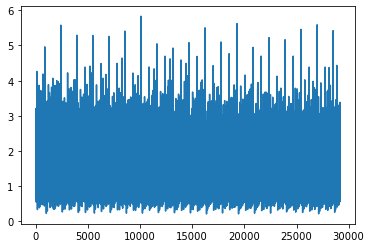

In [68]:
plt.plot(loss_list)

In [78]:
torch.save(model.state_dict(),'CharLevelRNN2_2.pth')

In [40]:
learning_rate = learning_rate*0.9

In [86]:
learning_rate

0.0009603999999999999

### Load model

In [89]:

model.load_state_dict(torch.load('CharLevelRNN2_2.pth'))
model.eval()

RNN(
  (fc1): Linear(in_features=92, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=28, bias=True)
  (tanh): Tanh()
)

In [14]:
model = model.to(device)


### generating names

In [62]:
def generate(a):

    a_enc = torch.zeros([1,28])

    a_enc[0,alphabets[a]] = 1
    hidden = model.initHidden(hidden_size)
    z = torch.cat((a_enc,hidden),1).to(device)
    hidden,out = model(z.to(device))
    #new_letter_enc = torch.tensor(out>=out.max(),dtype=int)
    letter = rev_alphabets[torch.argmax(out).item()]
    #print(out)
    out = F.softmax(out,dim=1)
    #print(out)
    a += letter

    while letter!='.':
        z = torch.cat((out,hidden),1).to(device)
        hidden,out = model(z.to(device))
        #new_letter_enc = torch.tensor(out>=out.max(),dtype=int)
        letter = rev_alphabets[torch.argmax(out).item()]
        out = F.softmax(out,dim=1)
        #print(out)
        a += letter
    return(a)


In [79]:
for i in alphabets:
    if i=='.':
        continue
    word = generate(i)
    print("for {} : {}".format(i,word))

for a : ausarasaurus.
for b : branantasaurus.
for c : crypaneoshosaur.
for d : drpsansasaus.
for e : euaaausaneasts.
for f : fanaaeaanaas.
for g : grapanasaurus.
for h : hapsitasaarus.
for i : isnasauaus.
for j : jaranananroisas.
for k : kanparasaurus.
for l : lapaalasaseus.
for m : mantacanatous.
for n : napnanastis.
for o : ostapasaurus.
for p : preatasaaaus.
for q : quaeamasatsaa.
for r : rapaaorasnus.
for s : sanpatanaa.
for t : tatanasaasae.
for u : ustestuaanas.
for v : vanaalasaurus.
for w : wanaalasaurus.
for x : xinualaanesas.
for y : yangansaneuss.
for z : zapaaaaaaeaus.


In [87]:
for i in alphabets:
    if i=='.':
        continue
    word = generate(i)
    print("for {} : {}".format(i,word))

for a : anaosataurus.
for b : brrcolosenis.
for c : crenocoeaeus.
for d : deooaephiaeus.
for e : euaocosasnes.
for f : fencaaosanatras.
for g : gongcuoaeeos.
for h : hualitosauau.
for i : inoosauau.
for j : jiansloanisaus.
for k : kunhorosanaalus.
for l : locoolaeieta.
for m : manoaaanessus.
for n : nateoaaanatas.
for o : ornatosaneaa.
for p : proarosaurus.
for q : qiaeialanasaus.
for r : riouariaeiaeu.
for s : stlnenosasus.
for t : tiaonocaeuesaurus.
for u : ustrslaaiue.
for v : velenosausaste.
for w : walaerosaurus.
for x : xiahosauais.
for y : yunoratasiu.
for z : zhunoacoalenau.


In [72]:
for i in range(1100,2000):
    print(names[i])

Protecovasaurus
Protiguanodon
Protoavis
Protoceratops
Protognathosaurus
Protognathus
Protohadros
Protorosaurus
Protorosaurus
Protrachodon
Proyandusaurus
Pseudolagosuchus
Psittacosaurus
Pteropelyx
Pterospondylus
Puertasaurus
Pukyongosaurus
Pulanesaura
Pycnonemosaurus
Pyroraptor
Qantassaurus
Qianzhousaurus
Qiaowanlong
Qijianglong
Qinlingosaurus
Qingxiusaurus
Qiupalong
Quaesitosaurus
Quetecsaurus
Quilmesaurus
Rachitrema
Rahiolisaurus
Rahona
Rahonavis
Rajasaurus
Rapator
Rapetosaurus
Raptorex
Ratchasimasaurus
Rativates
Rayososaurus
Razanandrongobe
Rebbachisaurus
Regaliceratops
Regnosaurus
Revueltosaurus
Rhabdodon
Rhadinosaurus
Rhinorex
Rhodanosaurus
Rhoetosaurus
Rhopalodon
Riabininohadros
Richardoestesia
Rileya
Rileyasuchus
Rinchenia
Rinconsaurus
Rioarribasaurus
Riodevasaurus
Riojasaurus
Riojasuchus
Rocasaurus
Roccosaurus
Rubeosaurus
Ruehleia
Rugocaudia
Rugops
Rukwatitan
Ruyangosaurus
Sacisaurus
Sahaliyania
Saichania
Saldamosaurus
Salimosaurus
Saltasaurus
Saltopus
Saltriosaurus
Sanchusaurus

IndexError: index 1536 is out of bounds for axis 0 with size 1536